In [1]:
import sys
sys.path.append('..')

import tomodpdt

import numpy as np
import time
import matplotlib.pyplot as plt

import deeplay as dl

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEV)

Using device: cuda


In [3]:

plotly_3d = False
save_folder = None
if save_folder is not None:
    import os
    os.makedirs(save_folder, exist_ok=True)

## 1 - Import 3D volume data

In this example we load in a 3D volume consisting of small gaussian blobs placed randomly inside the volume. The volume is 64x64x64 voxels in size, but can be up/downsampled to any size.



In [4]:
volume = tomodpdt.VOL_GAUSS_MULT

In [5]:
print(f"Shape of the volume: {volume.shape}")

Shape of the volume: (64, 64, 64)


In [6]:
# Visualize the volume in 3D space - needs plotly and ipywidgets
if plotly_3d:
    tomodpdt.plotting.visualize_3d_volume(volume)

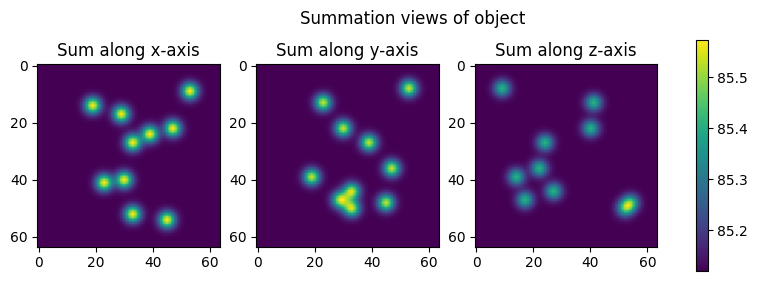

In [7]:
tomodpdt.plotting.plot_sum_object(volume)

## 2 - Choose imaging modality
We create images that are projections of the volume along a certain axis (in this case z-axis) by taking the sum of the pixel values along that axis.

There are two main types of imaging modalities here:

- `Sum3d2d`: Sum of pixel values along an axis
- `SumAvgWeighted3d2d`: Sum of pixel values along an axis weighted by the distance from the top of the volume

In [8]:
from tomodpdt.imaging_modality_torch import SumAvgWeighted3d2d, Sum3d2d

sum_model = Sum3d2d(dim=-1)

In [9]:
test_object, q_gt, projections, imaging_model = tomodpdt.simulate.create_data(
    volume=volume, # The volume we want to reconstruct
    image_modality=sum_model, # We use the sum model
    rotation_case='random_sinusoidal', # We rotate the object around 1 main axis, but the other 2 axes are also non-zero
    samples=200, # Number of projections
    duration=2 # Duration is the number of full revolutions
    )

Simulating... 50.0%


In [ ]:
data = np.load('D:/NewDataMonica/data_full_09_10_2024_HEK_03_04_us4.npz', allow_pickle=True)

projections = data['E'][400]

# Make projections 2 channels because it is now an imaginary field
projections = np.stack((projections.real, projections.imag), axis=-1)

# Add channel dimension

In [11]:
projections = projections[::4]
projections.shape

(125, 288, 288)

In [12]:
projections = torch.tensor(projections, dtype=torch.float32).unsqueeze(1)

#Downsample 2x
projections = nn.functional.avg_pool2d(projections, 2)


In [13]:
projections.shape

torch.Size([125, 1, 144, 144])

In [14]:
# Reshape the projections to 128x128 height and width with upsampling
projections = nn.functional.interpolate(projections, size=(64, 64), mode='bilinear', align_corners=False)

In [15]:
print(projections.shape)

torch.Size([125, 1, 64, 64])


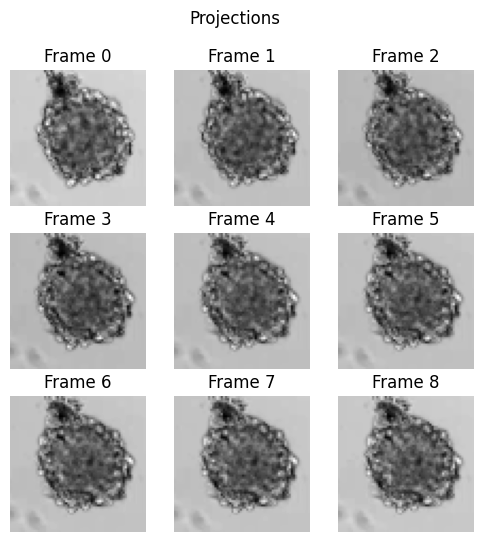

In [16]:
tomodpdt.plotting.plot_grid33_frames(projections, title="Projections")

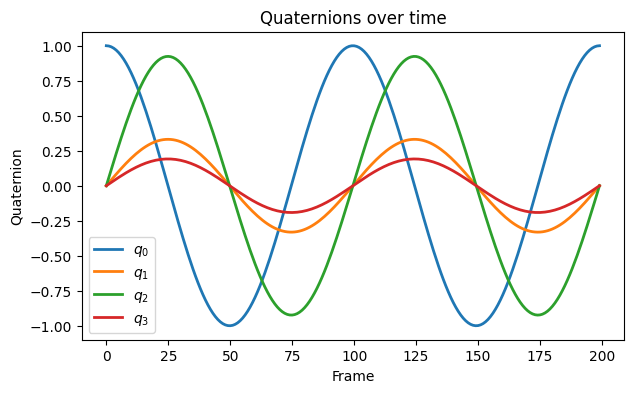

In [17]:
tomodpdt.plotting.plot_quaternions(q_gt)

## 3 - Tomographic reconstruction

### 3.1 - Set up the tomographic reconstruction class

In [18]:
from tomodpdt.imaging_modality_torch import setup_optics, imaging_model

# Setup the optics
optics_setttings = setup_optics(
        nsize=volume.shape[0], 
        padding_xy=64, 
        microscopy_regime='Brightfield', 
        NA=0.7, 
        wavelength=532e-9, 
        resolution=100e-9, 
        magnification=1, 
        return_field=False)

# Generate the imaging model
brightfield_model = imaging_model(optics_setup=optics_setttings)

In [19]:
N=volume.shape[0]

# Create the tomography model
tomo = tomodpdt.Tomography(
    volume_size=(N, N, N), # The size of the volume
    initial_volume='refraction', # 'refraction' since we are optimizing the refractive index
    rotation_optim_case='basis', # 'basis' or 'quaternion'
    imaging_model=brightfield_model, # The imaging model
    translation_maxmin=7, # The maximum translation in pixels
    )


### 3.2 - Initialize the parameters by producing a initial guess for the rotation parameters and the volume

In [20]:
# Initialize the parameters
tomo.initialize_parameters(projections, normalize=True)

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder             │ Sequential           │ 79.5 K │
│ 1 │ fc_mu               │ MultiLayerPerceptron │ 32.8 K │
│ 2 │ fc_var              │ MultiLayerPerceptron │ 32.8 K │
│ 3 │ fc_dec              │ MultiLayerPerceptron │ 51.3 K │
│ 4 │ decoder             │ Sequential           │ 61.0 K │
│ 5 │ reconstruction_loss │ BCELoss              │      0 │
│ 6 │ train_metrics       │ MetricCollection     │      0 │
│ 7 │ val_metrics         │ MetricCollection     │      0 │
│ 8 │ test_metrics        │ MetricCollection     │      0 │
│ 9 │ optimizer           │ Adam                 │      0 │
└───┴─────────────────────┴──────────────────────┴────────┘

Trainable params: 257 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 257 K                                                                                                
Total estimated model params size (MB): 1

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


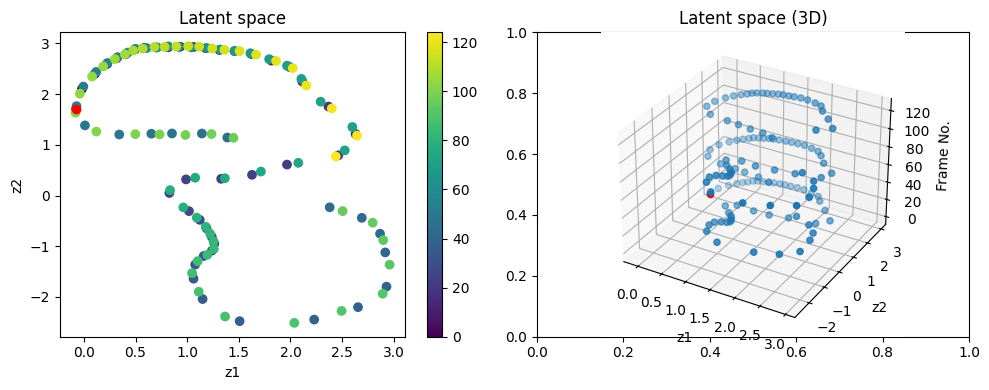

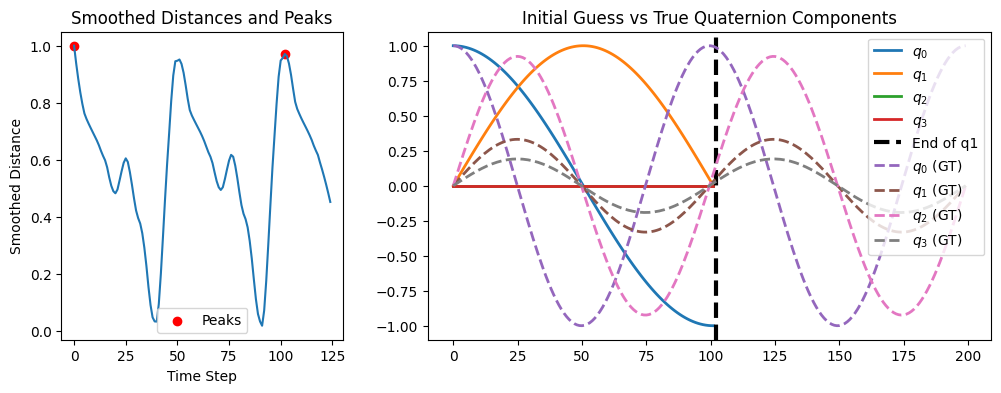

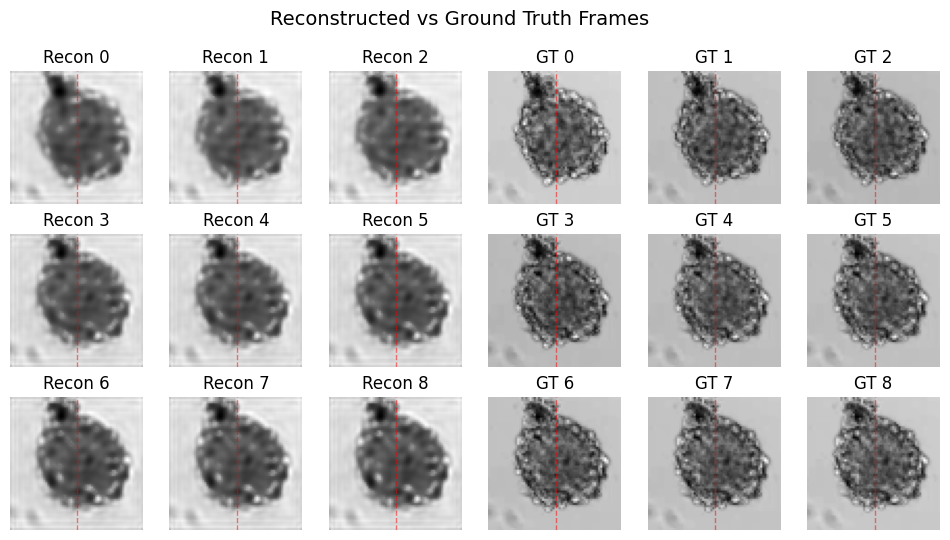

In [21]:
tomodpdt.plotting.plots_initial(tomo, gt=q_gt.to('cpu'), save_folder=save_folder)

### 3.3 - Validate that the initial rotation parameters are correct

In [22]:
N = len(tomo.frames) # Number of frames
idx = torch.arange(N) # Index of frames

### 3.4 - Optimize the 3D volume and the rotation parameters

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ vae_model     │ VariationalAutoEncoder │  257 K │
│ 1 │ encoder       │ Sequential             │ 79.5 K │
│ 2 │ fc_mu         │ MultiLayerPerceptron   │ 32.8 K │
│ 3 │ imaging_model │ imaging_model          │      0 │
│ 4 │ train_metrics │ MetricCollection       │      0 │
│ 5 │ val_metrics   │ MetricCollection       │      0 │
│ 6 │ test_metrics  │ MetricCollection       │      0 │
│ 7 │ optimizer     │ Adam                   │      0 │
│   │ other params  │ n/a                    │  150 K │
└───┴───────────────┴────────────────────────┴────────┘

Trainable params: 262 K                                                                                            
Non-trainable params: 257 K                                                                                        
Total params: 519 K                                                                                                
Total estimated model params size (MB): 2

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


c:\Users\Fredrik\Documents\GitHub\TomoDpDt\Notebooks\..\tomodpdt\image_modalities_dt.py:744: UserWarning: To copy 
construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 
sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pupils = [torch.tensor(pupil, dtype=torch.complex64).to(volume.device) for pupil in pupils]

Training time:  11.815502540270488  minutes


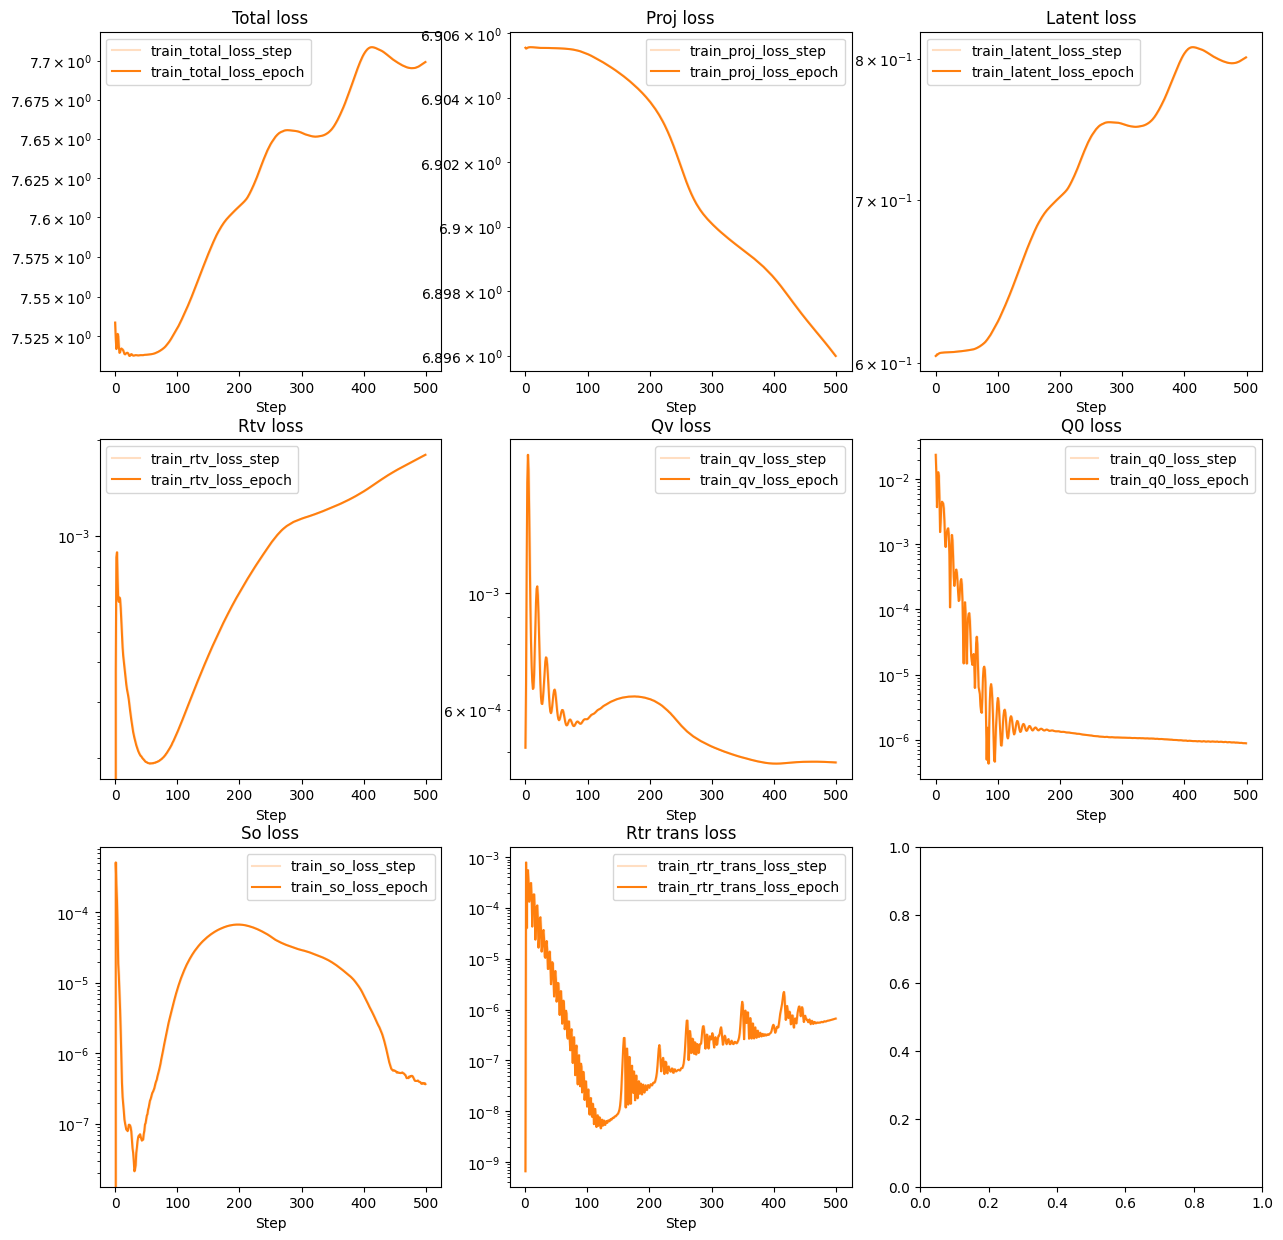

In [23]:
# Move the model to device
tomo.move_all_to_device(DEV)

# Train the model
start_time = time.time()
trainer = dl.Trainer(max_epochs=500, accelerator="auto", log_every_n_steps=10)
trainer.fit(tomo, DataLoader(idx, batch_size=128, shuffle=False))
print("Training time: ", (time.time() - start_time) / 60, " minutes")

# Plot the training history
try:
    trainer.history.plot()
except:
    print("No history to plot...")

## 4.0 - Visualize the reconstructed volume and the parameters

In [24]:
# Move it to the GPU if possible for faster plotting
tomo.move_all_to_device(DEV)

# Visualize the final volume and rotations.
plotter = tomodpdt.plotting.TomoPlotter(tomo)

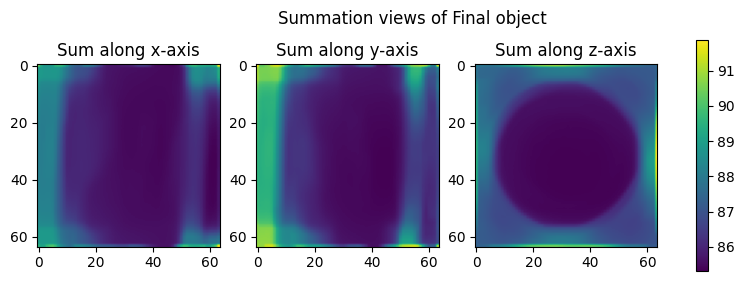

In [25]:
plotter.plot_sum_object(save_name="Final object")

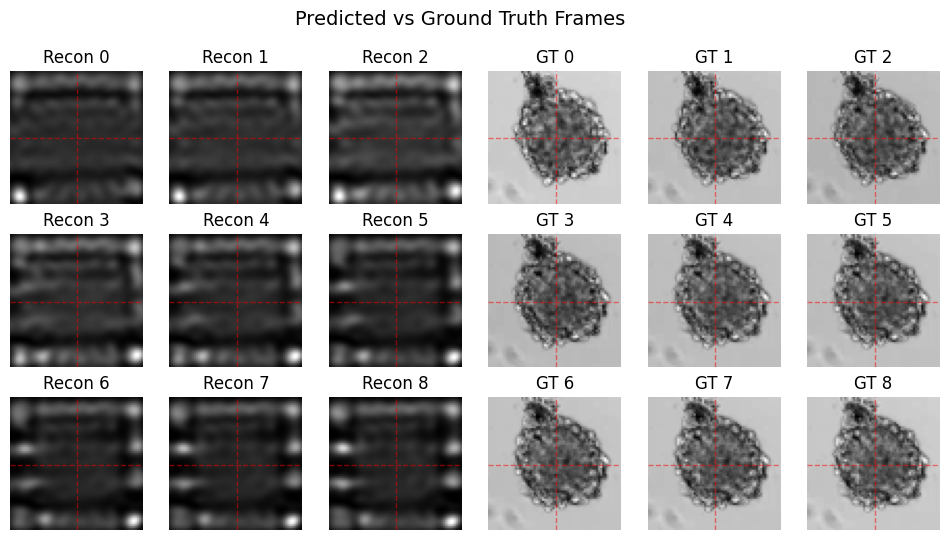

In [26]:
plotter.plot_reconstructed_vs_gt(column_headers=["Predicted", "Ground Truth"], forward=True, save_name="Reconstructed vs GT")

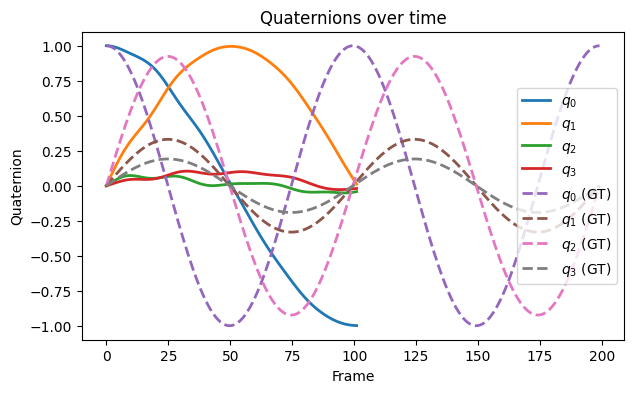

In [27]:
plotter.plot_quaternions(q_gt=q_gt)

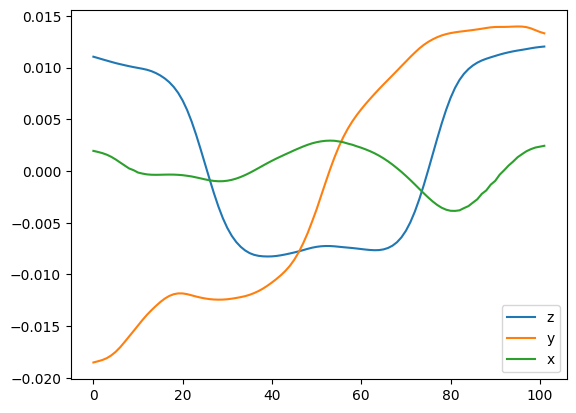

In [28]:
plt.plot(tomo.get_translations_final()[:, 0].detach().cpu().numpy(), label="z")
plt.plot(tomo.get_translations_final()[:, 1].detach().cpu().numpy(), label="y")
plt.plot(tomo.get_translations_final()[:, 2].detach().cpu().numpy(), label="x")
plt.legend()

## 5 - Save the reconstructed volume and the parameters